## AutoGen Swarm
Swarm implements a team in which agents can hand off task to other agents based on their capabilities. It is a multi-agent design pattern first introduced by OpenAI in an experimental project. The key idea is to let agent delegate tasks to other agents using a special tool call, while all agents share the same message context. This enables agents to make local decisions about task planning, rather than relying on a central orchestrator such as in SelectorGroupChat.

The speaker agent is selected based on the most recent HandoffMessage message in the context. This naturally requires each agent in the team to be able to generate HandoffMessage to signal which other agents that it hands off to.

In general, this is how it works:

1. Each agent has the ability to generate HandoffMessage to signal which other agents it can hand off to. For AssistantAgent, this means setting the handoffs argument.

2. When the team starts on a task, the first speaker agents operate on the task and make locallized decision about whether to hand off and to whom.

3. When an agent generates a HandoffMessage, the receiving agent takes over the task with the same message context.

4. The process continues until a termination condition is met.

## Load Azure Configurations

In [1]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Create Azure OpenAI Client

In [2]:
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# Create the token provider
#token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")

az_model_client = AzureOpenAIChatCompletionClient(
    azure_deployment=azure_openai_deployment,
    model=azure_openai_deployment,
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint,
    # azure_ad_token_provider=token_provider,  # Optional if you choose key-based authentication.
    api_key=azure_openai_key, # For key-based authentication.
)

from openai import AzureOpenAI

# Create the Dalle client
dalle_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
dalle_deployment_name = "dall-e-3"

# Create the Vision client
vision_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
vision_deployment_name = "gpt-4o"

## Creating the Agents

In [3]:
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.teams import Swarm
from autogen_agentchat.ui import Console
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path


# Define a tool
# This function calls the Dalle-3 image generator given the prompt and displays the generated image.
def generate_image(prompt: str) -> str:
    """
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.
    """

    print("Dalle Assistant Message: Creating the image ...")

    response = dalle_client.images.generate(
        model=dalle_deployment_name, prompt=prompt, size="1024x1024", quality="standard", n=1
    )

    # Retrieve the image URL from the response (assuming response structure)
    image_url = response.data[0].url

    # Open the image from the URL and save it to a temporary file.
    im = Image.open(requests.get(image_url, stream=True).raw)

    # Define the filename and path where the image should be saved.
    filename = "temp.jpg"
    local_path = Path(filename)

    # Save the image.
    im.save(local_path)

    # Get the absolute path of the saved image.
    full_path = str(local_path.absolute())

    img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

    # Return the full path of the saved image.
    print("Dalle Assistant Message: " + full_path)
    return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"

# Define an agent
dalle_assistant = AssistantAgent(
    name="dalle_assistant",
    description="This agent calls the Azure OpenAI Dall-e 3 model to generate an image from a text prompt coming from the user or a vision assistant.",
    handoffs=["planning_agent"],
    model_client=az_model_client,
    tools=[generate_image],
    system_message="""
    As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. 
    It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, 
    prior to delivering a response.

    Always handoff back to planner when image generation is complete.
    """,
)

In [4]:
# Analyze the image
def analyze_image() -> str:
    """
    Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
    """
    print("Vision Assistant Message: " + "Analyzing the image...")

    import base64
    from pathlib import Path

    # Create a Path object for the image file
    image_path = Path("temp.jpg")

    # Using a context manager to open the file with Path.open()
    with image_path.open("rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    content_images = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
        for base64_image in [base64_image]
    ]
    response = vision_client.chat.completions.create(
        model=vision_deployment_name,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                    },
                    *content_images,
                ],
            }
        ],
        max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    return response.choices[0].message.content

# Creating the vision assistant agent
vision_assistant = AssistantAgent(
    name="vision_assistant",
    description="This agent analyzes and critic an image and return the result. The resulting output should be a new prompt for dalle assistant that enhances the image based on the criticism and analysis",
    handoffs=["planning_agent"],
    model_client=az_model_client,
    tools=[analyze_image],
    system_message="""
    As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. 
    Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision 
    before you provide feedback to the user. You have access to the local file system where the image is stored.

    Always handoff back to planner when image analysis is complete.
    """,
)

In [5]:
# Create the user proxy agent.
user_proxy = UserProxyAgent("user_proxy", input_func=input)  # Use input() to get user input from console.

In [6]:
# create the planning agent
planning_agent = AssistantAgent(
    "planning_agent",
    description="An agent for planning tasks, this agent should be the first to engage when given a new task.",
    handoffs=["user_proxy", "dalle_assistant", "vision_assistant"],
    model_client=az_model_client,
    system_message=f"""
    You are a planning agent that coordinates the work of your team members.
    Coordinate handoff to specialized agents:
    - dalle assistant for image generation
    - vision assistant for image analysis and critique
    - dalle assistant for enhancing the image based on the analysis
    - final handoff to user proxy for final approval

     You will follow this sequence:
        Step 1: Dalle Assistant will generate an image based on the initial user prompt and display it for review.
        Step 2: Vision Assistant will analyze the image and provide a new prompt for Dalle Assistant to generate a new image based on the new prompt.
        Step 3: Dalle Assistant will generate an image based on the Vision Assistant prompt and display it for review.
        Step 4: Vision Assistant will analyze the image and provide a new prompt for Dalle Assistant to generate a new image based on the new prompt.
        Step 5: Dalle Assistant will generate an image based on the Vision Assistant prompt and display it for review.
        Step 6: Vision Assistant will analyze the image and provide a new prompt for Dalle Assistant to generate a new image based on the new prompt.
        Step 7: User Proxy will provide feedback on process.

    Always send your plan first, then handoff to appropriate agent.
    Always handoff to a single agent at a time.
    """,
)

## Creating the Team

In [7]:
text_mention_termination = TextMentionTermination("APPROVE")
max_messages_termination = MaxMessageTermination(max_messages=100)
termination = text_mention_termination | max_messages_termination

team = Swarm(
    participants=[planning_agent, dalle_assistant, vision_assistant, user_proxy], termination_condition=termination
)

## Specify the Task and Run the Team

---------- user ----------
Generate an image of a cat and dog chasing each other


---------- dalle_assistant ----------
[FunctionCall(id='call_9J5yIAqbFQy9mHmpWEtdUHXs', arguments='{"prompt":"a cat and dog chasing each other"}', name='generate_image')]
[Prompt tokens: 990, Completion tokens: 21]


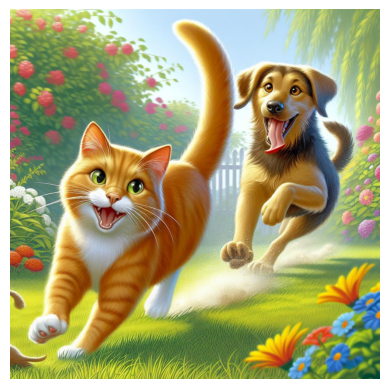

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_9J5yIAqbFQy9mHmpWEtdUHXs')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- dalle_assistant ----------
[FunctionCall(id='call_rMtYJSiU7KiXVLaBcSEucn8d', arguments='{}', name='transfer_to_planning_agent')]
[Prompt tokens: 1047, Completion tokens: 54]
---------- dalle_assistant ----------
[FunctionExecutionResult(content='Transferred to planning_agent, adopting the role of planning_agent immediately.', call_id='call_rMtYJSiU7KiXVLaBcSEucn8d')]
---------- dalle_assistant ----------
Transferred to planning_agent, adopting the role of planning_agent immediately.
---------- planning_agent ----------
[FunctionCall(id='call_KmW05iCo9k4BikJqAzoEEKz

Error processing publish message
Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.12/site-packages/autogen_core/_single_threaded_agent_runtime.py", line 397, in _process_publish
    await asyncio.gather(*responses)
  File "/home/codespace/.python/current/lib/python3.12/site-packages/autogen_core/_single_threaded_agent_runtime.py", line 389, in _on_message
    return await agent.on_message(
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.python/current/lib/python3.12/site-packages/autogen_core/_base_agent.py", line 113, in on_message
    return await self.on_message_impl(message, ctx)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.python/current/lib/python3.12/site-packages/autogen_agentchat/teams/_group_chat/_sequential_routed_agent.py", line 48, in on_message_impl
    return await super().on_message_impl(message, ctx)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.python/cu

---------- Summary ----------
Number of messages: 19
Finish reason: None
Total prompt tokens: 5574
Total completion tokens: 131
Duration: 22.83 seconds


In [10]:
task = "Generate an image of a cat and dog chasing each other"
response = await Console(team.run_stream(task=task))

## Printing whole response per agent source

In [ ]:
# ANSI escape code for bold text
bold_start = "\033[1m"
bold_end = "\033[0m"

# ANSI escape code for red text
red_start = "\033[31m"
red_end = "\033[0m"

for messages in response.messages:
    source = messages.source
    print(f"{bold_start}{red_start}{source}{bold_end}{red_end}")
    print(messages.content)